In [1]:
from BoomboxProcessor import BoomboxProcessor
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from train_encoding_model import BoomboxNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader

In [2]:
data_folder = "/home/shrey/Documents/eecs448-boombox/data/gtzan/"
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

boombox = BoomboxProcessor()
boombox.load_trajectories(data_folder, genres, "trajs.pkl")
boombox.load_encoding_model("models/model_50000.pt", BoomboxNet)
boombox.encode_trajectories()
boombox.split_encoded_trajectories(20)

In [3]:
trajs, labels = boombox.get_all_songlet_trajectories()

In [4]:
len(trajs), len(labels)

(999, 999)

In [5]:
trajs[0].shape

(20, 768)

In [6]:
# class GenreClassifier(nn.Module):
#     def __init__(self):
#         super(GenreClassifier, self).__init__()
        
#         self.conv_group = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(8),
#             nn.ReLU(),
#             nn.AvgPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.AvgPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.AvgPool2d(kernel_size=2, stride=2)
#         )
#         self.flatten = nn.Flatten()
#         self.droput = nn.Dropout(p=0.5)
#         self.fc1 = nn.Linear(6144, 1000)
#         self.fc2 = nn.Linear(1000, 10)
#         self.softmax = nn.Softmax(dim=1)
        
#     def forward(self, x):
#         x = self.conv_group(x)
#         x = self.flatten(x)
#         x = self.droput(x)
#         # print(x.shape)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         # x = self.fc1(x)
#         x = self.softmax(x)
#         return x

class GenreClassifier(nn.Module):
    def __init__(self):
        super(GenreClassifier, self).__init__()
        
        self.fc1 = nn.Linear(15360, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x, dim=0)
        return x

In [7]:
model = GenreClassifier().to('cuda')

In [15]:
# model.forward(torch.randn(1, 1, 20, 768).flatten().to('cuda')).shape
model.forward(torch.randn(1, 1, 20, 768).flatten().to('cuda')).shape

torch.Size([10])

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
X.reshape(-1, 1, 15360).shape

NameError: name 'X' is not defined

In [11]:
encoder = OneHotEncoder()
X = trajs.reshape((-1, 1, 20, 768))
y = encoder.fit_transform(labels.reshape(-1, 1)).toarray()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1, 15360), y, test_size=0.2, random_state=42)
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()


In [13]:
trainDataLoader = DataLoader(list(zip(X_train, y_train)), batch_size=64, shuffle=True)
testDataLoader = DataLoader(list(zip(X_test, y_test)), batch_size=64, shuffle=True)

In [16]:
num_epochs = 20

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in trainDataLoader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_correct += (torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)).sum().item()
        train_total += labels.size(0)
    
    train_loss = train_loss / train_total
    train_acc = train_correct / train_total

    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in testDataLoader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model(inputs)
            loss = criterion(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1))

            test_loss += loss.item() * inputs.size(0)
            test_correct += (torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)).sum().item()
            test_total += labels.size(0)
    
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total

    print(f"Train Loss: {train_loss}, Train Acc: {train_acc}, Test Loss: {test_loss}, Test Acc: {test_acc}")

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

torch.save(model.state_dict(), 'models/gtzan_classifier.pt')

RuntimeError: Expected target size [64, 10], got [64]

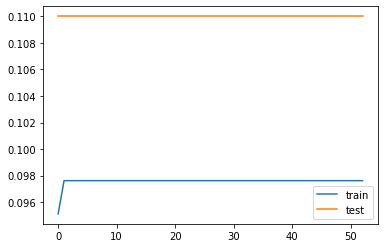

In [136]:
import matplotlib.pyplot as plt
plt.plot(train_acc_list, label='train')
plt.plot(test_acc_list, label='test')
plt.legend()

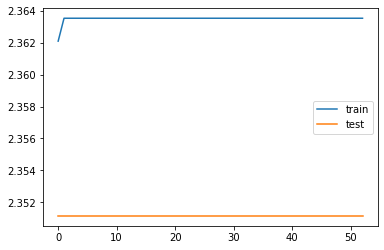

In [137]:
plt.plot(train_loss_list, label='train')
plt.plot(test_loss_list, label='test')
plt.legend()